### LSTM Multivariate - Air Pollution Forecasting

#### 1. Basic Data Preparation

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
df = pd.read_csv('pollution.csv', parse_dates = [['year', 'month', 'day', 'hour']],
                      index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)
# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)
# drop the first 24 hours that contain NaN values
df = df[24:]
# save to file
df.to_csv('pollution_processed.csv')
df.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


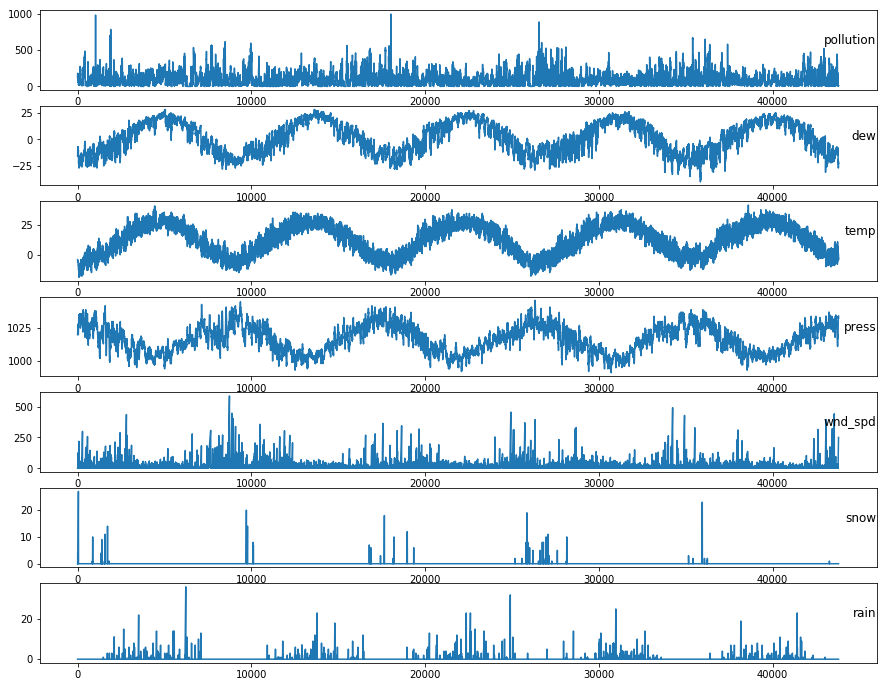

In [4]:
# plots each series as a separate subplot, except wnd_dir, which is categorical.
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(15,12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

#### 2. Multivariate LSTM Forecast Model

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
df = pd.read_csv('pollution_processed.csv', header=0, index_col=0)
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.head())
print(reframed.shape)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var7(t-1)  var8(t-1)  \
3   0.000000        0.0   0.148893   0.367647  ...   0.000000        0.0   
4   0.000000        0.0   0.159960   0.426471  ...   0.037037        0.0   
5   0.000000        0.0   0.182093   0.485294  ...   0.074074        0.0   
6   0.037037        0.0   0.138833   0.485294  ...   0.111111        0.0   
7   0.074074        0.0   0.109658   0.485294  ...   0.148148        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
3  0.182093  0.485294  0.229508  0.563637

In [18]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
# X are the features from t-3, t-2 and t-1, Y is var1 t
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [19]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [13]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0510 - val_loss: 0.0417
Epoch 2/50
 - 1s - loss: 0.0252 - val_loss: 0.0271
Epoch 3/50
 - 1s - loss: 0.0216 - val_loss: 0.0210
Epoch 4/50
 - 1s - loss: 0.0208 - val_loss: 0.0196
Epoch 5/50
 - 1s - loss: 0.0202 - val_loss: 0.0191
Epoch 6/50
 - 1s - loss: 0.0197 - val_loss: 0.0189
Epoch 7/50
 - 1s - loss: 0.0192 - val_loss: 0.0185
Epoch 8/50
 - 1s - loss: 0.0187 - val_loss: 0.0181
Epoch 9/50
 - 1s - loss: 0.0183 - val_loss: 0.0177
Epoch 10/50
 - 2s - loss: 0.0176 - val_loss: 0.0172
Epoch 11/50
 - 1s - loss: 0.0173 - val_loss: 0.0173
Epoch 12/50
 - 1s - loss: 0.0168 - val_loss: 0.0168
Epoch 13/50
 - 1s - loss: 0.0165 - val_loss: 0.0169
Epoch 14/50
 - 1s - loss: 0.0158 - val_loss: 0.0166
Epoch 15/50
 - 1s - loss: 0.0157 - val_loss: 0.0166
Epoch 16/50
 - 1s - loss: 0.0153 - val_loss: 0.0164
Epoch 17/50
 - 1s - loss: 0.0149 - val_loss: 0.0164
Epoch 18/50
 - 1s - loss: 0.0149 - val_loss: 0.0160
Epoch 19/50
 - 1s - loss

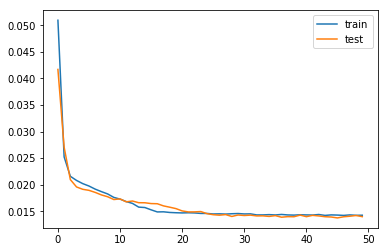

In [14]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
test_X.shape

(35037, 3, 8)

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.498
